**IMPORT LIBRARIES**

In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import warnings

from datetime import datetime
from matplotlib import pyplot
from numpy import where

warnings.filterwarnings("ignore")

In [8]:
data = pd.read_csv('/content/customer_churm_prediction_train.csv')
data["created_at_bill"] = pd.to_datetime(data["created_at_bill"]).dt.date
data.head()

,bill_ref_id,store_ref_id,customer_ref_id,doctor_ref_id,payment_method,created_at_bill,num_drugs_bill,total_quantity_bill,mrp_bill,total_spend_bill,return_value_bill,returned_quantity_bill,quantity_ethical,quantity_generic,quantity_surgical,quantity_ayurvedic,quantity_general,quantity_otc,quantity_chronic,quantity_acute,quantity_h1
0,7562292,468,6251676,6628790,cash,2019-04-01,3,12,394.60,146.92,0.0,0,0,11,1,0,0,0,10,2,0
1,7562335,468,6702206,7298144,cash,2019-04-01,1,1,50.50,26.04,0.0,0,0,1,0,0,0,0,0,1,0
2,7562354,468,6689660,6478435,cash,2019-04-01,3,7,708.50,330.19,0.0,0,0,7,0,0,0,0,0,7,0
3,7562366,468,8539983,6755214,cash,2019-04-01,1,1,52.32,26.00,0.0,0,0,1,0,0,0,0,0,1,0
4,7562370,468,8539984,7298144,cash,2019-04-01,1,1,18.00,14.40,0.0,0,0,1,0,0,0,0,0,1,0


In [9]:
test_target = pd.read_csv('/content/customer_churm_prediction_test.csv')
test_target = test_target.rename(columns={"oct_purchase_flag": "flag"})
test_target.head()

,customer_ref_id,flag
0,6251676,0
1,6702206,0
2,6689660,1
3,8539983,0
4,8539984,0


**EXPLORITORY DATA ANALYSIS**

In [39]:
data.shape

(963561, 22)

In [40]:
df_pivot = pd.DataFrame({'types': data.dtypes,
                         'nulls': data.isna().sum(),
                         '% nulls': data.isna().sum() / data.shape[0],
                         'size': data.shape[0],
                         'uniques': data.nunique()})
df_pivot

,types,nulls,% nulls,size,uniques
bill_ref_id,int64,0,0.0,963561,963561
store_ref_id,int64,0,0.0,963561,41
customer_ref_id,int64,0,0.0,963561,243069
doctor_ref_id,int64,0,0.0,963561,65595
payment_method,object,0,0.0,963561,6
created_at_bill,object,0,0.0,963561,153
num_drugs_bill,int64,0,0.0,963561,49
total_quantity_bill,int64,0,0.0,963561,248
mrp_bill,float64,0,0.0,963561,180567
total_spend_bill,float64,0,0.0,963561,201678


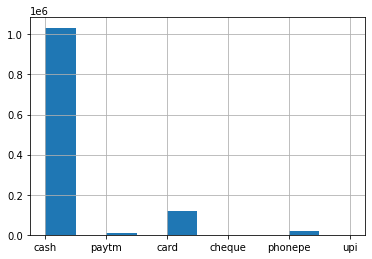

In [12]:
data.payment_method.hist()

In [13]:
for i in [7898076, 6754310, 6076893]:
  print(data[data["customer_ref_id"]==i ][["customer_ref_id","payment_method","total_spend_bill","total_quantity_bill"]])

        customer_ref_id payment_method  total_spend_bill  total_quantity_bill
50493           7898076            NaN           925.225                    5
52855           7898076           cash          1133.475                    3
53795           7898076           card           124.100                    1
54096           7898076           card           363.800                    2
55262           7898076           card           584.800                    2
119497          7898076           card           224.350                    2
138202          7898076           card           326.700                    2
598525          7898076           card           501.250                    5
721139          7898076           card           748.000                    2
         customer_ref_id payment_method  total_spend_bill  total_quantity_bill
53120            6754310           cash             55.02                    4
53268            6754310        phonepe            209.70     

*Create a target variable for the training set*

In [14]:
data["payment_method"].loc[50493] = "card"
data["payment_method"].loc[82850] = "phonepe"
data["payment_method"].loc[83285] = "cash"

test = data.copy()

In [15]:
data.describe()

,bill_ref_id,store_ref_id,customer_ref_id,doctor_ref_id,num_drugs_bill,total_quantity_bill,mrp_bill,total_spend_bill,return_value_bill,returned_quantity_bill,quantity_ethical,quantity_generic,quantity_surgical,quantity_ayurvedic,quantity_general,quantity_otc,quantity_chronic,quantity_acute,quantity_h1
count,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06,1.184025e+06
mean,1.513761e+07,4.354155e+02,8.040392e+06,7.460049e+06,2.383723e+00,4.588893e+00,4.979271e+02,3.067370e+02,8.634467e+00,9.909250e-02,1.847541e+00,2.441612e+00,1.479758e-01,4.447964e-02,7.285319e-02,1.413568e-02,2.174291e+00,2.414602e+00,3.990541e-02
std,2.310106e+06,2.597328e+01,1.318602e+06,9.739071e+05,2.080232e+00,8.138829e+00,1.047531e+03,6.111760e+02,1.439748e+02,2.291848e+00,4.165740e+00,5.599285e+00,2.159626e+00,3.027468e-01,1.247458e+00,2.518561e-01,4.699598e+00,6.052490e+00,5.857927e-01
min,7.562292e+06,3.550000e+02,5.672731e+06,6.478335e+06,1.000000e+00,1.000000e+00,9.500000e-01,1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.329776e+07,4.140000e+02,6.874296e+06,6.536417e+06,1.000000e+00,1.000000e+00,1.060000e+02,5.729000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,1.606025e+07,4.390000e+02,8.195925e+06,7.158275e+06,2.000000e+00,2.000000e+00,2.453100e+02,1.404900e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.697584e+07,4.560000e+02,8.994398e+06,8.192855e+06,3.000000e+00,5.000000e+00,5.952300e+02,3.609000e+02,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
max,1.779181e+07,4.730000e+02,1.080290e+07,1.026242e+07,8.100000e+01,1.527000e+03,3.977398e+05,1.696770e+05,5.821130e+04,1.514000e+03,7.970000e+02,1.187000e+03,1.200000e+03,4.100000e+01,4.000000e+02,1.000000e+02,3.000000e+02,1.514000e+03,1.800000e+02


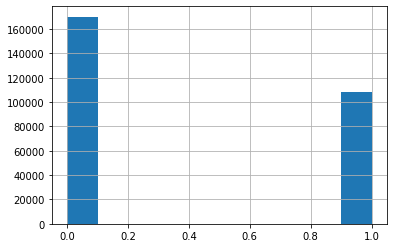

In [16]:
target = data.copy()

target["flag"] = [1 if i.month == 9 else 0 for i in target["created_at_bill"]]

target = target.sort_values('created_at_bill').groupby('customer_ref_id').tail(1)

target = target[['customer_ref_id','flag']]

target.flag.hist()

In [17]:
target.head()

,customer_ref_id,flag
39297,8225738,0
39298,8544553,0
39300,7623120,0
39305,6661457,0
39311,7100451,0


*Organize the data for the training and test set*

In [18]:
data["flag"] = [1 if x.month == 9 else 0 for x in data["created_at_bill"]]
print(data.flag.value_counts())

data = data[data["flag"] == 0]
print(data.flag.value_counts())

data = data.drop('flag', axis=1)

0    963561
1    220464
Name: flag, dtype: int64
0    963561
Name: flag, dtype: int64


*Table 1: Grouped data mean of each numeric value*

In [19]:
#training data
summary_reg = data.groupby('customer_ref_id')[[col for col in data if col not in ["doctor_ref_id", "customer_ref_id", "bill_ref_id", "store_ref_id", "payment_method" "created_at_bill"]]].agg(['mean'])
summary_reg.columns = ['_'.join(col).strip() for col in summary_reg.columns.values]

#test data
summary_reg_test = test.groupby('customer_ref_id')[[col for col in test if col not in ["doctor_ref_id", "customer_ref_id", "bill_ref_id", "store_ref_id", "payment_method" "created_at_bill"]]].agg(['mean'])
summary_reg_test.columns = ['_'.join(col).strip() for col in summary_reg_test.columns.values]

*Table 2: Count number of times each customer made a purchase*

In [20]:
#training set
data["count"] = 1
payment = data[["customer_ref_id", "count"]].groupby(by="customer_ref_id").count()

#test set
test["count"] = 1
payment_test = test[["customer_ref_id", "count"]].groupby(by="customer_ref_id").count()

*Table 3: Get payment method and "days before" variable*

In [21]:
# TRAINING SET

#sort the data
d_sort = data.sort_values(['customer_ref_id', 'created_at_bill'], ascending=[1, 1])

#take the last instance of each customer_ref_id sorted by created_at_bill and keep necessary variables
d_sort2 = d_sort.sort_values('created_at_bill').groupby('customer_ref_id').tail(1)
d_sort2 = d_sort2[['customer_ref_id', 'created_at_bill','payment_method']]

#to train we will do days before September but when we test the model we will use October
from datetime import datetime
end = datetime.strptime('01/09/19', '%d/%m/%y').date()

#Create days before vaariable
d_sort2['days_before'] = [(end - x).days for x in d_sort2["created_at_bill"]]
d_sort2 = d_sort2[["customer_ref_id", "payment_method","days_before"]]

# TEST SET

#sort the data
d_sort_test = test.sort_values(['customer_ref_id', 'created_at_bill'], ascending=[1, 1])

#take the last instance of each customer_ref_id sorted by created_at_bill and keep necessary variables
d_sort2_test = d_sort_test.sort_values('created_at_bill').groupby('customer_ref_id').tail(1)
d_sort2_test = d_sort2_test[['customer_ref_id', 'created_at_bill','payment_method']]

#to train we will do days before September but when we test the model we will use October
end_test = datetime.strptime('01/10/19', '%d/%m/%y').date()

#Create days before vaariable
d_sort2_test['days_before'] = [(end_test - x).days for x in d_sort2_test["created_at_bill"]]
d_sort2_test = d_sort2_test[["customer_ref_id", "payment_method","days_before"]]

*Merge count to grouped data using customer ref id*

In [22]:
#training set
merged = summary_reg.merge(payment, how="left", on="customer_ref_id").merge(d_sort2, how="left", on="customer_ref_id")

#test set
merged_test = summary_reg_test.merge(payment_test, how="left", on="customer_ref_id").merge(d_sort2_test, how="left", on="customer_ref_id")

*One hot encoding to fix the payment_method varible*

In [23]:
#training set
merged2 = pd.get_dummies(merged)

#test set
test = pd.get_dummies(merged_test)

*Append target variable to the datasets*

In [24]:
#training set
train = merged2.merge(target, how="left", on="customer_ref_id")

#test set
test = test.merge(test_target, how="left", on="customer_ref_id")

*Correlation*

Text(0.5, 1.0, 'Heatmap of all the Features of Train data set')

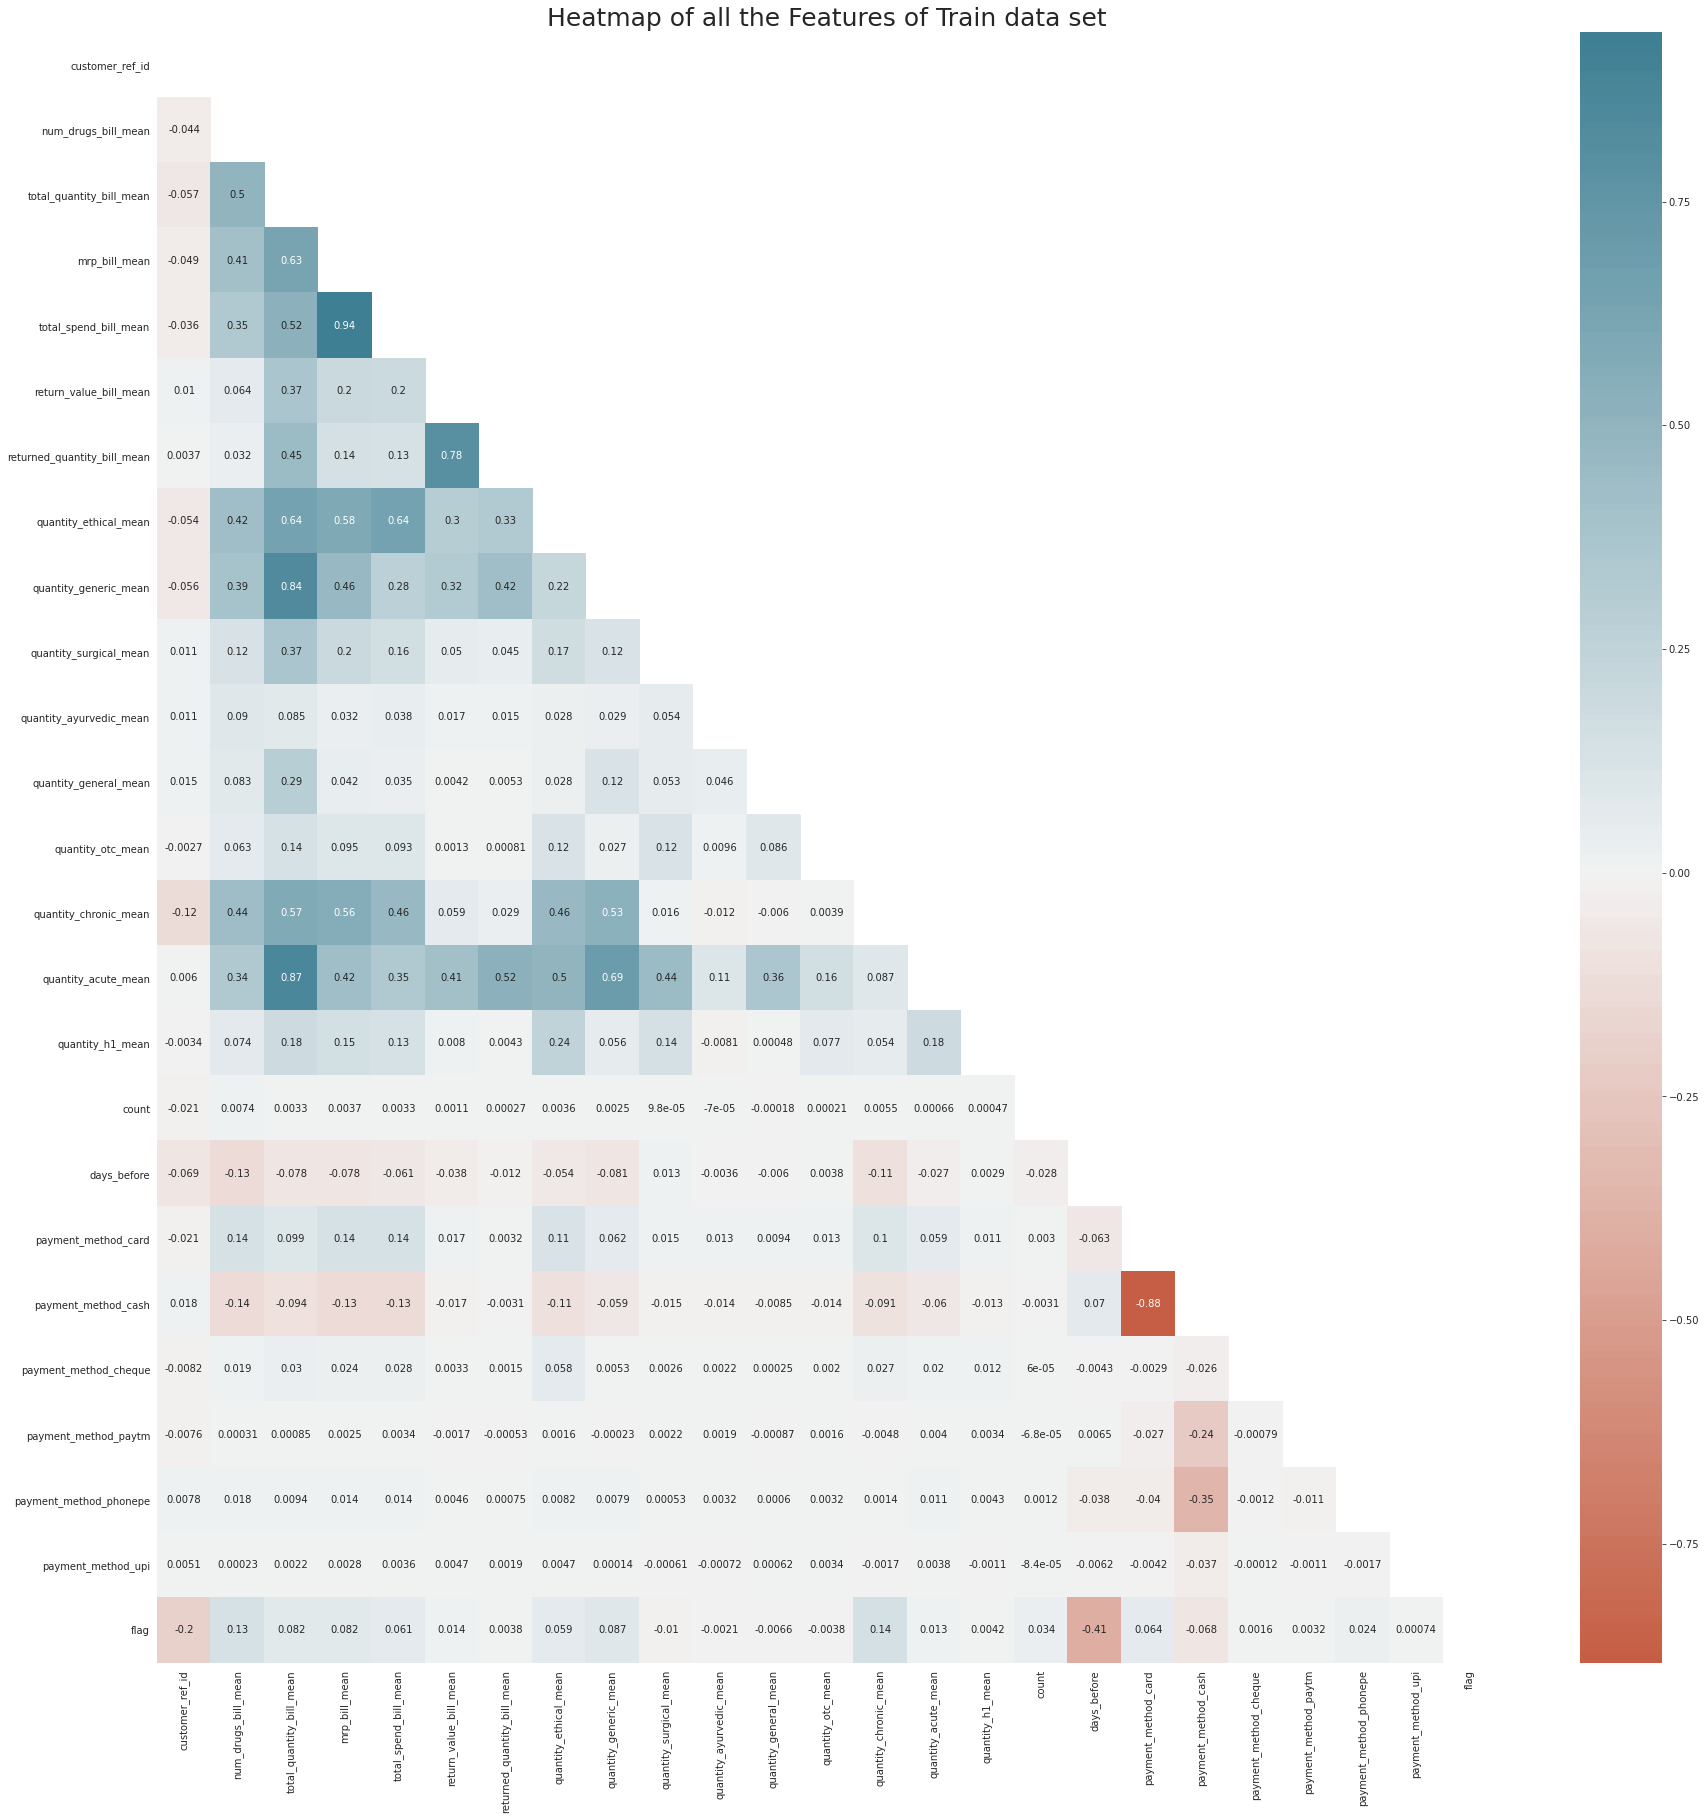

In [25]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,30))
## Plotting heatmap. Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25)

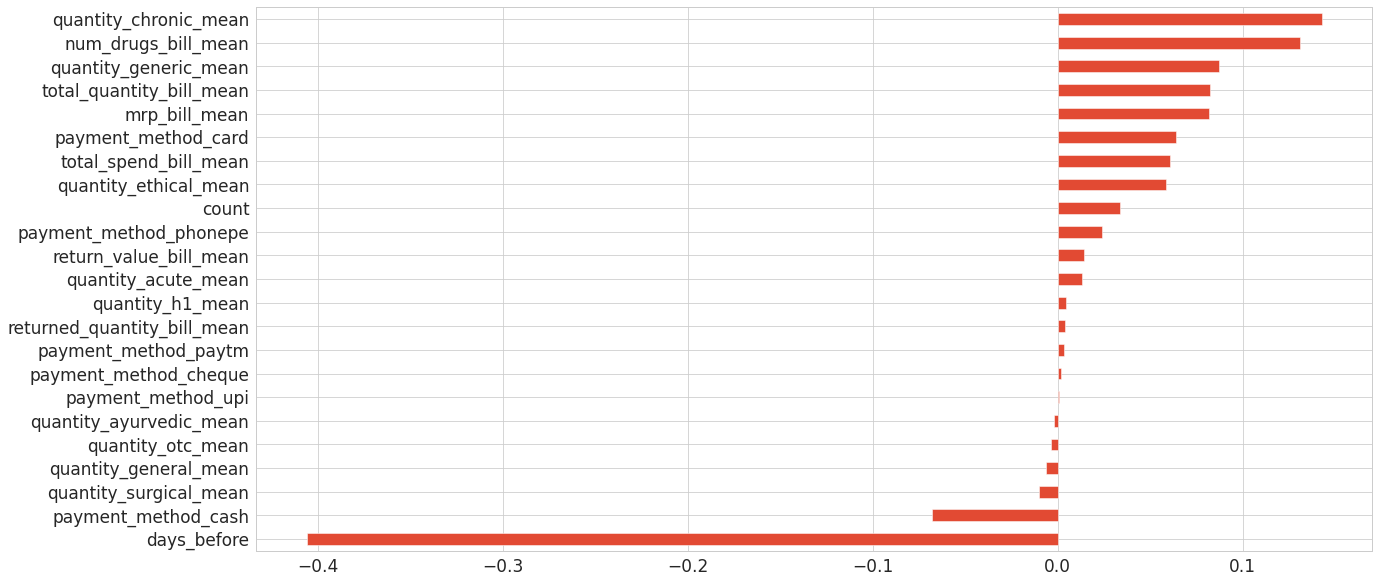

In [26]:
corr = train[train.columns[1:]].corr()['flag'][:].sort_values(ascending=True)
# print(corr)

corr[:-1].plot(kind='barh', figsize = (20,10), fontsize = 17)

**MODELING**

In [27]:
#Libraries for modeling
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Import required libraries for performance metrics
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# Import required libraries for machine learning classifiers
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [28]:
train = train.drop(columns=['customer_ref_id'])
test = test.drop(columns=['customer_ref_id'])

In [29]:
print(train.shape)
print(test.shape)

(243069, 24)
(278136, 24)


**MODEL OUTPUT**

In [30]:
accuracies = {}
kappaScores= {}
f1scores={}

def Models(models, X_train, X_test, y_train, y_test, title):
    model = models
    model.fit(X_train,y_train)
    
    test_matrix = pd.crosstab(y_test, model.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
    
    g2 = sns.heatmap(test_matrix, annot=True, fmt=".1f",cbar=False)
    g2.set_title(title)
    g2.set_ylabel('Total Observed October Sales = {}'.format(y_test.sum()), rotation=90)
    g2.set_xlabel('Accuracy score for Testing Dataset = {}'.format(accuracy_score(model.predict(X_test), y_test)))
    
    #record metrics
    accuracies[title]=accuracy_score(model.predict(X_test), y_test)*100
    f1scores[title]=f1_score(model.predict(X_test), y_test)*100
    kappaScores[title]=cohen_kappa_score(model.predict(X_test), y_test)*100
    
    plt.show()

In [31]:
import plotly.graph_objects as go

def Featureimportances(models, X_train, y_train):
    model = models
    model.fit(X_train,y_train)
    importances = model.feature_importances_
    features = X_train.columns
    if len(importances)<len(features): 
        features = X_train.columns[:len(importances)]
    else:
        importances = model.feature_importances_[:len(features)]
    imp = pd.DataFrame({'Features': features, 'Importance': importances})
    imp = imp.sort_values(by = 'Importance', ascending=False)[:15]
    imp['Sum Importance'] = imp['Importance'].cumsum()
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=imp.Features,y=imp.Importance, marker=dict(color=list(range(20)), colorscale="Sunsetdark")))

    fig.update_layout(title="Feature Importance",
                      xaxis_title="Features", yaxis_title="Importance",title_x=0.5, paper_bgcolor="mintcream",
                      title_font_size=20)
    fig.show()

In [32]:
X_train = train.drop(columns=['flag'],axis=1)
y_train = train['flag']

X_test = test.drop(columns=['flag'],axis=1)
y_test = test['flag']

In [33]:
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

# Instantiate the machine learning classifiers
log_model = LogisticRegression(max_iter=10000)
svc_model = LinearSVC(dual=False)
dtr_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()
xgb_model = XGBClassifier()
lgb_model = LGBMClassifier()
knn_model = KNeighborsClassifier(n_neighbors=3)
gbc_model = GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_features=2, max_depth=2, random_state=0)
lda_model = LinearDiscriminantAnalysis()

In [34]:
def models_evaluation(X, y, folds):
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)
    
    xgb = cross_validate(xgb_model, X, y, cv=folds, scoring=scoring)
    lgb = cross_validate(lgb_model, X, y, cv=folds, scoring=scoring)
    knn = cross_validate(knn_model, X, y, cv=folds, scoring=scoring)
    gbc = cross_validate(gbc_model, X, y, cv=folds, scoring=scoring)
    lda = cross_validate(lda_model, X, y, cv=folds, scoring=scoring)


    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean(),
                                                               log['fit_time'].mean(),
                                                               log['score_time'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean(),
                                                                   svc['fit_time'].mean(),
                                                                   svc['score_time'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean(),
                                                       dtr['fit_time'].mean(),
                                                       dtr['score_time'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean(),
                                                       rfc['fit_time'].mean(),
                                                       rfc['score_time'].mean()],
                                       
                                      'XGB':[xgb['test_accuracy'].mean(),
                                                              xgb['test_precision'].mean(),
                                                              xgb['test_recall'].mean(),
                                                              xgb['test_f1_score'].mean(),
                                                              xgb['fit_time'].mean(),
                                                              xgb['score_time'].mean()],
                                        
                                       'LGB':[lgb['test_accuracy'].mean(),
                                                              lgb['test_precision'].mean(),
                                                              lgb['test_recall'].mean(),
                                                              lgb['test_f1_score'].mean(),
                                                              lgb['fit_time'].mean(),
                                                              lgb['score_time'].mean()],
                                        
                                       'KNN':[knn['test_accuracy'].mean(),
                                                              knn['test_precision'].mean(),
                                                              knn['test_recall'].mean(),
                                                              knn['test_f1_score'].mean(),
                                                              knn['fit_time'].mean(),
                                                              knn['score_time'].mean()],
                                        
                                       'GBC':[gbc['test_accuracy'].mean(),
                                                              gbc['test_precision'].mean(),
                                                              gbc['test_recall'].mean(),
                                                              gbc['test_f1_score'].mean(),
                                                              gbc['fit_time'].mean(),
                                                              gbc['score_time'].mean()],
                                        
                                        'LDA':[lda['test_accuracy'].mean(),
                                                              lda['test_precision'].mean(),
                                                              lda['test_recall'].mean(),
                                                              lda['test_f1_score'].mean(),
                                                              lda['fit_time'].mean(),
                                                              lda['score_time'].mean()],
                                       
                                       'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean(),
                                                              gnb['fit_time'].mean(),
                                                              gnb['score_time'].mean()]},
                                       
                                       
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'fit_time', 'score_time'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)

In [35]:
models_evaluation(X_train, y_train, 5)

,Logistic Regression,Support Vector Classifier,Decision Tree,Random Forest,XGB,LGB,KNN,GBC,LDA,Gaussian Naive Bayes,Best Score
Accuracy,0.793741,0.789701,0.680325,0.776006,0.798921,0.798789,0.726057,0.794317,0.724069,0.716356,XGB
Precision,0.769696,0.785170,0.467372,0.654458,0.750847,0.752188,0.550747,0.737563,0.674424,0.546836,Support Vector Classifier
Recall,0.486931,0.448776,0.535553,0.550651,0.550391,0.548662,0.519041,0.539405,0.426771,0.603300,Gaussian Naive Bayes
F1 Score,0.563994,0.536110,0.497180,0.580074,0.600925,0.598330,0.532012,0.590401,0.471595,0.535721,XGB
fit_time,33.723023,1.783796,2.603928,36.277025,15.990428,3.020695,8.308646,26.640946,0.742662,0.115669,Random Forest
score_time,0.081584,0.077865,0.070574,1.688641,0.200460,0.281678,5.567454,0.264758,0.090363,0.066186,KNN


**EXPLORE MODEL METRICS**

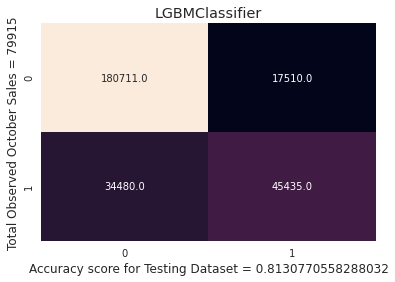

CPU times: user 11.8 s, sys: 147 ms, total: 11.9 s
Wall time: 11.8 s


In [36]:
title = 'LGBMClassifier'
%time Models(LGBMClassifier(),X_train, X_test, y_train, y_test, title)